# Style transfer nn with PyTorch

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
dtype = torch.cuda.FloatTensor

In [3]:
imsize = 128

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(loader(image))
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image


style_img = image_loader("images/picasso.jpg").type(dtype)
content_img = image_loader("images/photo.jpg").type(dtype)

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

/usr/lib/python3.6/site-packages/torch/cuda/__init__.py:97: UserWarning: 
    Found GPU0 GeForce GT 740M which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


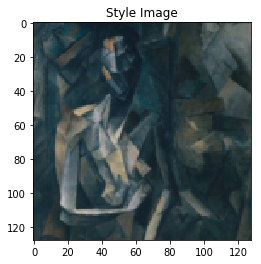

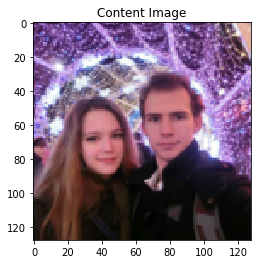

In [4]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.clone().cpu()  # we clone the tensor to not do changes on it
    image = image.view(3, imsize, imsize)  # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img.data, title='Style Image')

plt.figure()
imshow(content_img.data, title='Content Image')


In [6]:
class ContentLoss(nn.Module):

    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        self.target = target.detach() * weight
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.loss = self.criterion(input * self.weight, self.target)
        self.output = input
        return self.output

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

In [7]:
class GramMatrix(nn.Module):

    def forward(self, input):
        batches, feature_maps, m, n = input.size()  # a=batch size(=1)
        # b=number of feature maps
        # (c,d)=dimensions of a f. map (N=c*d)

        features = input.view(batches * feature_maps, m * n)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(batches * feature_maps * m * n)


In [8]:
class StyleLoss(nn.Module):

    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion(self.G, self.target)
        return self.output

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

In [16]:
cnn = models.vgg19(pretrained=True).features.cuda()

In [9]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']


def get_style_model_and_losses(cnn, style_img, content_img,
                               style_weight=1000, content_weight=1,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    model = nn.Sequential()  # the new Sequential module network
    gram = GramMatrix()  # we need a gram module in order to compute style targets

    
    model = model.cuda()
    gram = gram.cuda()

    i = 1
    for layer in list(cnn):
        if isinstance(layer, nn.Conv2d):
            name = "conv_" + str(i)
            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)

        if isinstance(layer, nn.ReLU):
            name = "relu_" + str(i)
            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)

            i += 1

        if isinstance(layer, nn.MaxPool2d):
            name = "pool_" + str(i)
            model.add_module(name, layer)  # ***

    return model, style_losses, content_losses


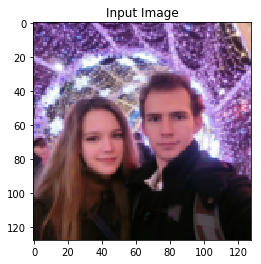

In [10]:
input_img = content_img.clone()
# if you want to use a white noise instead uncomment the below line:
# input_img = Variable(torch.randn(content_img.data.size())).type(dtype)

# add the original input image to the figure:
plt.figure()
imshow(input_img.data, title='Input Image')


In [11]:
def get_input_param_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    input_param = nn.Parameter(input_img.data)
    optimizer = optim.LBFGS([input_param])
    return input_param, optimizer


In [14]:
def run_style_transfer(cnn, content_img, style_img, input_img, num_steps=300,
                       style_weight=1000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        style_img, content_img, style_weight, content_weight)
    input_param, optimizer = get_input_param_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_param.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_param)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.backward()
            for cl in content_losses:
                content_score += cl.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.data[0], content_score.data[0]))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_param.data.clamp_(0, 1)

    return input_param.data

In [17]:
output = run_style_transfer(cnn, content_img, style_img, input_img)

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 1.807819 Content Loss: 2.055786

run [100]:
Style Loss : 0.996611 Content Loss: 1.774271

run [150]:
Style Loss : 0.558410 Content Loss: 1.708057

run [200]:
Style Loss : 0.369632 Content Loss: 1.648621

run [250]:
Style Loss : 0.349514 Content Loss: 1.582183

run [300]:
Style Loss : 0.343679 Content Loss: 1.553178



In [19]:
output = run_style_transfer(cnn, content_img, style_img, Variable(output), num_steps=1000)

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 0.337850 Content Loss: 1.542529

run [100]:
Style Loss : 0.335407 Content Loss: 1.539681

run [150]:
Style Loss : 0.333830 Content Loss: 1.536541

run [200]:
Style Loss : 0.335192 Content Loss: 1.534252

run [250]:
Style Loss : 0.331470 Content Loss: 1.529765

run [300]:
Style Loss : 0.331284 Content Loss: 1.526199

run [350]:
Style Loss : 0.330804 Content Loss: 1.524269

run [400]:
Style Loss : 0.330646 Content Loss: 1.522650

run [450]:
Style Loss : 0.330590 Content Loss: 1.521116

run [500]:
Style Loss : 0.330026 Content Loss: 1.520284

run [550]:
Style Loss : 0.329498 Content Loss: 1.519725

run [600]:
Style Loss : 0.328437 Content Loss: 1.519479

run [650]:
Style Loss : 0.329300 Content Loss: 1.519184

run [700]:
Style Loss : 0.328006 Content Loss: 1.519441

run [750]:
Style Loss : 0.326759 Content Loss: 1.517571

run [800]:
Style Loss : 0.326398 Content Loss: 1.517564

run [850]:
Style Loss : 0.325973 Content

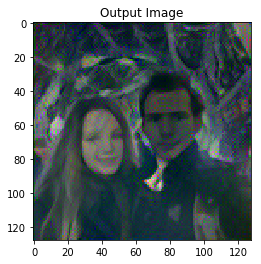

In [20]:
plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()